In [1]:
import uproot
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import awkward as ak

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook"])

In [2]:
rpath = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v0/root/LSTNtuple_MLTraining_v1.root"
)

In [3]:
tree = uproot.open(rpath)["tree"]

In [12]:
tree.keys()

['sim_pt',
 'sim_eta',
 'sim_phi',
 'sim_pca_dxy',
 'sim_pca_dz',
 'sim_q',
 'sim_event',
 'sim_pdgId',
 'sim_vx',
 'sim_vy',
 'sim_vz',
 'sim_trkNtupIdx',
 'sim_TC_matched',
 'sim_TC_matched_idx',
 'sim_TC_matched_mask',
 'tc_pt',
 'tc_eta',
 'tc_phi',
 'tc_type',
 'tc_isFake',
 'tc_isDuplicate',
 'tc_matched_simIdx',
 'sim_dummy',
 'tc_dummy',
 'pT5_matched_simIdx',
 'pT5_hitIdxs',
 'sim_pT5_matched',
 'pT5_pt',
 'pT5_eta',
 'pT5_phi',
 'pT5_isFake',
 'pT5_isDuplicate',
 'pT5_score',
 'pT5_layer_binary',
 'pT5_moduleType_binary',
 'pT5_matched_pt',
 'pT5_rzChiSquared',
 'pT5_rPhiChiSquared',
 'pT5_rPhiChiSquaredInwards',
 'sim_pT3_matched',
 'pT3_pt',
 'pT3_isFake',
 'pT3_isDuplicate',
 'pT3_eta',
 'pT3_phi',
 'pT3_score',
 'pT3_foundDuplicate',
 'pT3_matched_simIdx',
 'pT3_hitIdxs',
 'pT3_pixelRadius',
 'pT3_pixelRadiusError',
 'pT3_matched_pt',
 'pT3_tripletRadius',
 'pT3_rPhiChiSquared',
 'pT3_rPhiChiSquaredInwards',
 'pT3_rzChiSquared',
 'pT3_layer_binary',
 'pT3_moduleType_binar

In [4]:
ETA_THLD = 8

In [5]:
s = []
for i in tqdm(range(100)):
    pid = tree["MD_sim_idx"].array()[i].to_numpy()
    pt = tree["MD_sim_pt"].array()[i].to_numpy()
    eta = tree["MD_sim_eta"].array()[i].to_numpy()
    s.extend(
        pd.Series(pid[(pt > 0.9) & (np.abs(eta) < ETA_THLD)]).value_counts().to_list()
    )

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


(array([ 4858.,  7061.,  5823.,  5250.,  8163., 21190., 24631., 19167.,
        11638.,  5476.,  2361.,   891.,   554.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14.]),
 <BarContainer object of 13 artists>)

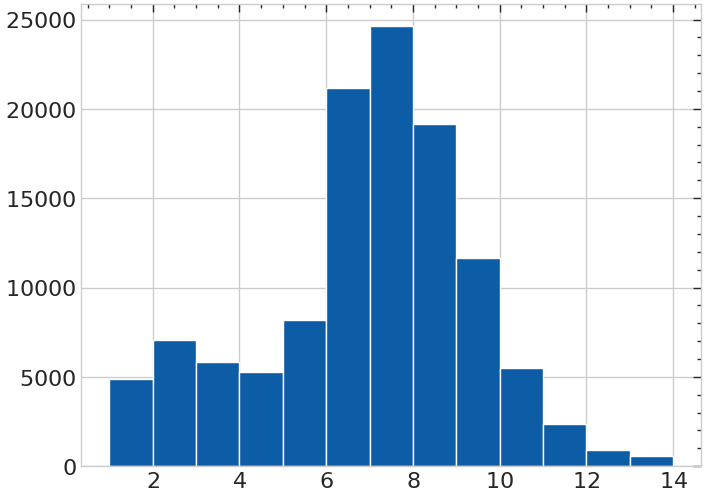

In [6]:
from matplotlib import pyplot as plt

plt.hist(s, bins=range(1, 15))

In [7]:
from collections import defaultdict
import torch
from gnn_tracking.analysis.graphs import (
    get_track_graph_info_from_data,
    get_largest_segment_fracs,
)

dpath = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v0/processed"
)
fracs = defaultdict(list)
etas = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for f in tqdm(list(dpath.glob("*.pt"))[:10], total=10):
    data = torch.load(dpath / "0001.pt")
    data.y = data.y.long()
    for eta in etas:
        # this is stupid, we should just take the pids and merge on the
        # etas, but we can't do that right now
        fracs[eta].extend(
            get_largest_segment_fracs(
                data=data,
                pt_thld=0.9,
                max_eta=eta,
            ).tolist()
        )

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.48it/s]


(array([2.669e+03, 2.369e+03, 2.317e+03, 2.896e+03, 2.372e+03, 1.191e+03,
        4.600e+01, 8.000e+00, 1.000e+00, 4.000e+00]),
 array([6.94102840e-04, 4.30982351e-01, 8.61270547e-01, 1.29155886e+00,
        1.72184706e+00, 2.15213537e+00, 2.58242345e+00, 3.01271176e+00,
        3.44300008e+00, 3.87328815e+00, 4.30357647e+00]),
 <BarContainer object of 10 artists>)

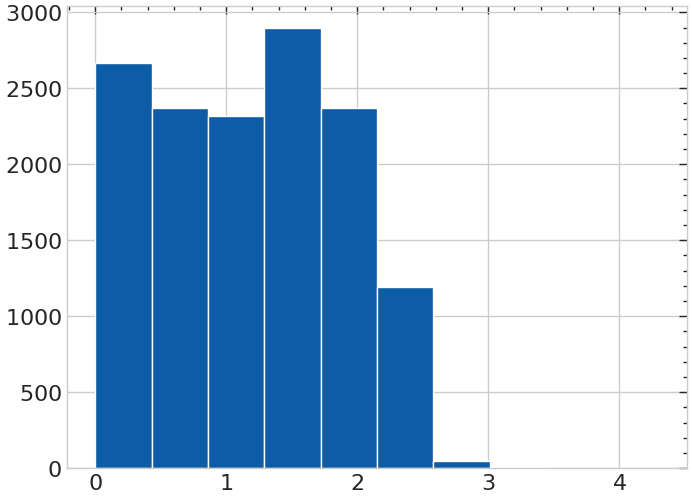

In [8]:
plt.hist(data.eta.abs()[data.eta.abs() < 10])

In [9]:
df = pd.DataFrame(index=etas)
df["eta"] = df.index
dfracs = {eta: np.array(fs) for eta, fs in fracs.items()}
df["frac25"] = [(dfracs[eta] > 0.25).mean() for eta in etas]
df["frac50"] = [(dfracs[eta] > 0.48).mean() for eta in etas]
df["frac100"] = [(dfracs[eta] > 0.99).mean() for eta in etas]

Text(0.5, 0, '$\\eta$ cut')

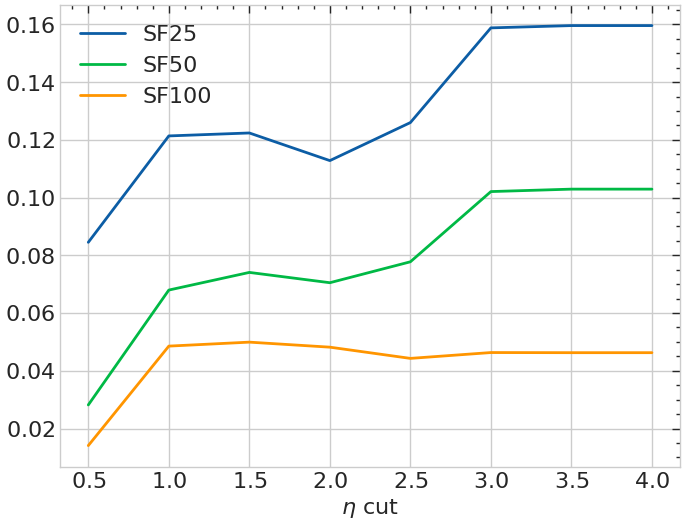

In [10]:
fig, ax = plt.subplots()
ax.plot("eta", "frac25", data=df, label="SF25")
ax.plot("eta", "frac50", data=df, label="SF50")
ax.plot("eta", "frac100", data=df, label="SF100")
ax.legend()
ax.set_xlabel("$\eta$ cut")